In [49]:
import numpy as np
import matplotlib.pyplot as plt
import wandb

In [29]:
def get_val_metrics(runs, index):
    run_f1_scores = {}
    run_auroc_val_scores = {}
    
    for run in runs:
        history = run.history(pandas=True)
        val_f1_scores = history['f1_val'].dropna().tolist()
        auroc_val_scores = history['auroc_val'].dropna().tolist()
        
        run_f1_scores[run.id] = val_f1_scores
        run_auroc_val_scores[run.id] = auroc_val_scores
    
    mean_f1_scores = [f1_scores[index] for f1_scores in run_f1_scores.values()]
    mean_auroc_val_scores = [auroc_val_scores[index] for auroc_val_scores in run_auroc_val_scores.values()]
    
    overall_mean_f1 = np.mean(mean_f1_scores)
    overall_std_f1 = np.std(mean_f1_scores)
    
    overall_mean_auroc_val = np.mean(mean_auroc_val_scores)
    overall_std_auroc_val = np.std(mean_auroc_val_scores)
    
    print(f"Mean F1 score for the {index}th epoch across all runs: {overall_mean_f1:.4f}")
    print(f"Std. F1 score for the {index}th epoch across all runs: {overall_std_f1:.4f}")
    
    print(f"Mean AUROC VAL score for the {index}th epoch across all runs: {overall_mean_auroc_val:.4f}")
    print(f"Std. AUROC VAL score for the {index}th epoch across all runs: {overall_std_auroc_val:.4f}")
    return list(run_f1_scores.values()), list(run_auroc_val_scores.values())

In [30]:
wandb.init(mode='disabled')

# transformer

In [31]:
entity = 'cell-x'
project = 'g0-arrest-uni-cv5'

runs1 = wandb.Api().runs(f"{entity}/{project}")


In [32]:
entity = 'cell-x'
project = 'g0-arrest-resnet50-cv5'
runs2 =  wandb.Api().runs(f"{entity}/{project}")

In [33]:
entity = 'cell-x'
project = 'g0-arrest-gigapath-cv5'
runs3 =  wandb.Api().runs(f"{entity}/{project}")

In [34]:
# def get_f1_mean_val(runs, index):
    
#     run_f1_scores = {}
#     run_auroc_val_scores = {}
#     # Iterate over the runs
#     for run in runs:
#         # Retrieve the run history for the current run
#         history = run.history(pandas=True)
        
#         # Extract the validation F1 scores from the history
#         val_f1_scores = history['f1_val'].dropna().tolist()
#         auroc_val_scores = history['auroc_val'].dropna().tolist()
        
#         # Store the validation F1 scores for the current run
#         run_f1_scores[run.id] = val_f1_scores
#         run_auroc_val_scores[run.id] = auroc_val_scores

#     # # Print the validation F1 scores for each run
#     # for run_id, f1_scores in run_f1_scores.items():
#     #     print(f"Run ID: {run_id}")
#     #     print(f"Validation F1 Scores: {f1_scores}")
#     #     print()
#     mean_f1_scores = []
#     mean_auroc_val_scores = []
    
#     index += 1
#     for run_id, f1_scores in run_f1_scores.items():
#         # Get the F1 score for the 7th epoch
#         f1_ith_epoch = f1_scores[index]  # Assuming 0-based indexing
        
#         # Append the F1 score to the list
#         mean_f1_scores.append(f1_ith_epoch)
#         mean_auroc_val_scores.append(run_auroc_val_scores[run_id][index])
#     # Compute the mean of the F1 scores for the ith epoch
#     overall_mean_f1 = np.mean(mean_f1_scores)
#     overall_std_f1 = np.std(mean_f1_scores)


#     overall_mean_auroc_val = np.mean(mean_auroc_val_scores)
#     overall_std_auroc_val  = np.std(mean_auroc_val_scores)

#     print(f"Mean F1 score for the {index}th epoch across all runs: {overall_mean_f1:.4f}")
#     print(f"Std. F1 score for the {index}th epoch across all runs: {overall_std_f1:.4f}")

#     print(f"Mean AUROC VAL score for the {index}th epoch across all runs: {overall_mean_auroc_val:.4f}")
#     print(f"Std. AUROC VAL score for the {index}th epoch across all runs: {overall_std_auroc_val:.4f}")

In [35]:
uni_f1_scores, uni_aurocval_scores = get_val_metrics(runs=runs1, index=8)
resnet50_f1_scores, resnet50_aurocval_scores = get_val_metrics(runs=runs2, index=8)
gigapath_f1_scores, gigapath_aurocval_scores = get_val_metrics(runs=runs3, index=8)


Mean F1 score for the 8th epoch across all runs: 0.6786
Std. F1 score for the 8th epoch across all runs: 0.0299
Mean AUROC VAL score for the 8th epoch across all runs: 0.7318
Std. AUROC VAL score for the 8th epoch across all runs: 0.0339
Mean F1 score for the 8th epoch across all runs: 0.6691
Std. F1 score for the 8th epoch across all runs: 0.0415
Mean AUROC VAL score for the 8th epoch across all runs: 0.7426
Std. AUROC VAL score for the 8th epoch across all runs: 0.0260
Mean F1 score for the 8th epoch across all runs: 0.6584
Std. F1 score for the 8th epoch across all runs: 0.0520
Mean AUROC VAL score for the 8th epoch across all runs: 0.7425
Std. AUROC VAL score for the 8th epoch across all runs: 0.0263


In [44]:
len(uni_f1_scores[1])
uni_f1_scores[0]

[0.4888888895511627,
 0.6717557311058044,
 0.6545454263687134,
 0.678260862827301,
 0.6274510025978088,
 0.6842105388641357,
 0.6542056202888489,
 0.6666666865348816,
 0.6666666865348816]

# f1 scores

In [60]:
uni_f1_scores
def get_mean_std(scores):
    means = [np.mean([sublist[i] for sublist in scores]) for i in range(len(scores[0]))]
    stds = [np.std([sublist[i] for sublist in scores]) for i in range(len(scores[0]))]
    return means, stds
# uni_means = [np.mean([sublist[i] for sublist in uni_f1_scores]) for i in range(len(uni_f1_scores[0]))]
# uni_stds = [np.std([sublist[i] for sublist in uni_f1_scores]) for i in range(len(uni_f1_scores[0]))]
# resnet50_means = [np.mean([sublist[i] for sublist in resnet50_f1_scores]) for i in range(len(resnet50_f1_scores[0]))]
# resnet50_stds = [np.std([sublist[i] for sublist in resnet50_f1_scores]) for i in range(len(resnet50_f1_scores[0]))]
# gigapath_means = [np.mean([sublist[i] for sublist in gigapath_f1_scores]) for i in range(len(gigapath_f1_scores[0]))]
# gigapath_stds = [np.std([sublist[i] for sublist in gigapath_f1_scores]) for i in range(len(gigapath_f1_scores[0]))]
uni_means, uni_stds = get_mean_std(uni_f1_scores)
resnet50_means, resnet50_stds = get_mean_std(resnet50_f1_scores)
gigapath_means, gigapath_stds = get_mean_std(gigapath_f1_scores)

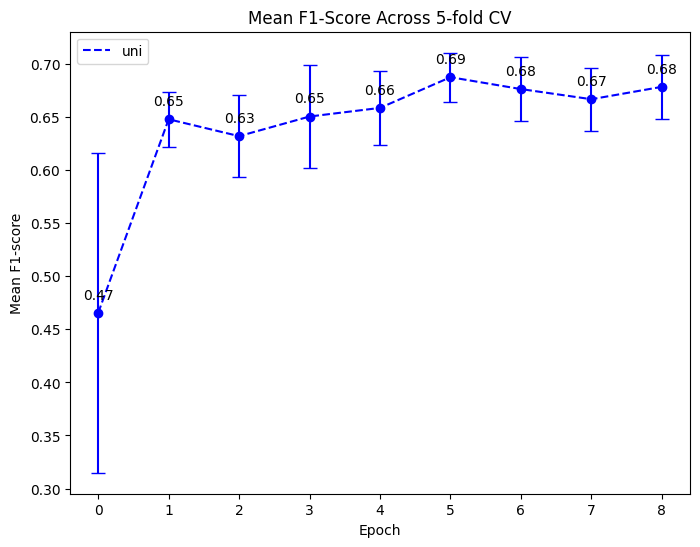

In [65]:
# Create the x-axis values
x = range(0, 9)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the mean with error bars
ax.errorbar(x, uni_means, yerr=uni_stds, fmt='o', capsize=5, color='b')

# Connect the mean values with lines
ax.plot(x, uni_means, linestyle='--', color='b', label='uni')
ax.plot(x, resnet50_means, linestyle='--', color='r', label='resnet50')
ax.plot(x, gigapath_means, linestyle='--', color='g', label='gigapath')


# Add labels for the mean values
for i, mean in enumerate(uni_means):
    ax.annotate(f"{mean:.2f}", (i, mean), xytext=(0, 10), textcoords="offset points", ha="center")
ax.legend()

# Set the axis labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean F1-score')
ax.set_title('Mean F1-Score Across 5-fold CV')

# Set the x-axis ticks
ax.set_xticks(x)

# Show the plot
plt.show()

In [53]:
get_val_metrics(runs=runs1, index=6)


Mean F1 score for the 6th epoch across all runs: 0.6765
Std. F1 score for the 6th epoch across all runs: 0.0303
Mean AUROC VAL score for the 6th epoch across all runs: 0.7307
Std. AUROC VAL score for the 6th epoch across all runs: 0.0346


wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wand

### RESNET50

In [42]:
get_val_metrics(runs=runs2, index=7)


Mean F1 score for the 8th epoch across all runs: 0.6691
Std. F1 score for the 8th epoch across all runs: 0.0415
Mean AUROC VAL score for the 8th epoch across all runs: 0.7426
Std. AUROC VAL score for the 8th epoch across all runs: 0.0260


In [45]:
get_val_metrics(runs=runs2, index=5)


Mean F1 score for the 6th epoch across all runs: 0.6752
Std. F1 score for the 6th epoch across all runs: 0.0224
Mean AUROC VAL score for the 6th epoch across all runs: 0.7388
Std. AUROC VAL score for the 6th epoch across all runs: 0.0257


wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


In [52]:
wandb.finish()

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
